<a href="https://colab.research.google.com/github/mahimna/625-721-Project/blob/main/625_721_Research_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 7.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
!pip install pandas-bokeh

In [3]:
!pip install rpy2==2.9.4

     |████████████████████████████████| 194 kB 5.2 MB/s 
  Created wheel for rpy2: filename=rpy2-2.9.4-cp37-cp37m-linux_x86_64.whl size=318259 sha256=15736f80040b487977d9a08af5eee3e595bfb5ad8eb8ea2ef70cff050f176bbd
  Stored in directory: /root/.cache/pip/wheels/a3/82/4d/024c3738fd4a1bdef15e5d70deafb2059f9706906e46d56614
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.5
    Uninstalling rpy2-3.4.5:
      Successfully uninstalled rpy2-3.4.5


In [4]:
!pip install thresholdmodeling

In [5]:
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_bokeh
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

base = importr('base')
utils = importr('utils')
utils.chooseCRANmirror(ind=1)
utils.install_packages('POT') #installing POT package

from thresholdmodeling import thresh_modeling
from bokeh.models import NumeralTickFormatter, FixedTicker
from bokeh.plotting import figure, show, output_notebook

pandas_bokeh.output_notebook()

/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cloud.r-project.org/src/contrib/POT_1.1-7.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1028906 bytes (1004 KB)

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.7/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.7/

In [6]:
spy = yf.Ticker("SPY")

In [7]:
def plot_close_values_and_returns(values, returns, percentile):
  index = int(len(values)*percentile / 100)
  values[0:index].plot_bokeh(kind='line')
  returns[1:index].plot_bokeh(kind='line')

In [11]:
def get_thresholds(returns, data_percentile, threshold_percentile):
  index = int(len(returns)*data_percentile / 100)
  thresh_modeling.MRL(returns[1:index], 0.05)
  thresh_modeling.Parameter_Stability_plot(returns[1:index], 0.05)
  precentile_threshold = np.percentile(returns[1:index], threshold_percentile)
  return precentile_threshold

In [9]:
def estimate_parameters(returns, data_percentile, threshold):
  index = int(len(returns)*data_percentile / 100)
  vals = thresh_modeling.gpdfit(returns[1:index], threshold, 'mle')
  thresh_modeling.gpdpdf(returns[1:index], threshold, 'mle', 'sturges', 0.05)
  thresh_modeling.gpdcdf(returns[1:index], threshold, 'mle', 0.05)

In [10]:
def plot_returns_and_above_threshold_returns(returns, data_percentile, threshold):
  index = int(len(returns)*data_percentile / 100)
  above_threshold_df = returns[1:index][returns[1:index] > threshold]
  
  returns_histogram, returns_edges = np.histogram(returns[1:index], bins=30)
  returns_p = figure(title="Close Returns")
  returns_p.quad(top=returns_histogram, bottom=0, left=returns_edges[:-1], right=returns_edges[1:], line_color=None)

  returns_p.xaxis[0].formatter = NumeralTickFormatter(format="0.0")
  show(returns_p)

  above_threshold_np, above_threshold_edges = np.histogram(above_threshold_df, bins=30)
  above_threshold_p = figure(title="Above Threshold Returns")
  above_threshold_p.quad(top=above_threshold_np, bottom=0, left=above_threshold_edges[:-1], right=above_threshold_edges[1:], line_color=None)

  above_threshold_p.xaxis[0].formatter = NumeralTickFormatter(format="0.0")
  show(above_threshold_p) 


In [12]:
def find_cdf_of_max_value(returns, data_percentile, threshold, scale, shape):
  index = int(len(returns)*data_percentile / 100)
  max_value = max(returns[index:])
  cdf = 1-pow(1+(shape*(max_value-threshold))/scale, -1/shape)
  return cdf

In [13]:
def find_pdf_of_max_value(returns, data_percentile, threshold, scale, shape):
  index = int(len(returns)*data_percentile / 100)
  max_value = max(returns[index:])
  cdf = 1-pow(1+(shape*(max_value-threshold))/scale, -1/shape)
  pdf = (1/scale)*pow(1+(shape*(max_value-threshold))/(scale), -1/shape-1)
  return pdf

In [14]:
def find_percentage_of_remaining_in_99(returns, data_percentile, threshold, scale, shape):
  index = int(len(returns)*data_percentile / 100)
  remaining = returns[index:]
  num_99 = 0.0
  num_greater_than_threshold = 0
  for val in remaining:
    if val >= threshold:
      num_greater_than_threshold += 1
      cdf = 1-pow(1+(shape*(val-threshold))/scale, -1/shape)
      if cdf >= 0.99:
        print(val)
        print(cdf)
        num_99 += 1
  print(num_99)
  print(num_greater_than_threshold)
  print("percentage: " + str(num_99 / num_greater_than_threshold*100))
  return num_99 / num_greater_than_threshold*100

In [15]:
hist_daily = spy.history(start="2010-01-01", end="2021-10-30")
hist_daily['Close_Returns'] = (hist_daily['Close'].shift(1) - hist_daily['Close'])/(hist_daily['Close'])*100
hist_daily

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_Returns
Date,,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,118944600,0,0,NaN
2010-01-05,113.260002,113.680000,112.849998,113.629997,111579900,0,0,-0.264011
2010-01-06,113.519997,113.989998,113.430000,113.709999,116074400,0,0,-0.070356
2010-01-07,113.500000,114.330002,113.180000,114.190002,131091100,0,0,-0.420355
2010-01-08,113.889999,114.620003,113.660004,114.570000,126402800,0,0,-0.331673
...,...,...,...,...,...,...,...,...
2021-10-25,454.279999,455.899994,452.390015,455.549988,45214507,0,0,-0.533420
2021-10-26,457.200012,458.489990,455.559998,455.959991,56075116,0,0,-0.089921
2021-10-27,456.450012,457.160004,453.859985,453.940002,72437997,0,0,0.444990


In [18]:
hist_weekly = spy.history(start="2010-01-01", end="2021-10-30", interval="1wk")
hist_weekly['Close_Returns'] = (hist_weekly['Close'].shift(1) - hist_weekly['Close'])/(hist_weekly['Close'])*100
hist_weekly

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_Returns
Date,,,,,,,,
2010-01-01,112.370003,114.330002,111.510002,114.190002,477690000,0,0,NaN
2010-01-08,113.889999,115.139999,113.220001,114.930000,673652800,0,0,-0.643868
2010-01-15,114.730003,115.129997,111.559998,111.699997,912805600,0,0,2.891677
2010-01-22,111.199997,111.739998,107.910004,108.570000,1332016300,0,0,2.882930
2010-01-29,109.040001,110.589996,106.419998,106.440002,1244316900,0,0,2.001125
...,...,...,...,...,...,...,...,...
2021-10-01,430.980011,441.679993,426.359985,438.660004,533962327,0,0,-2.170243
2021-10-08,439.480011,442.660004,431.540009,442.500000,354182656,0,0,-0.867796
2021-10-15,444.750000,453.829010,443.269989,453.589996,266347272,0,0,-2.444938


In [20]:
plot_close_values_and_returns(hist_daily['Close'], hist_daily['Close_Returns'], 100)

In [21]:
plot_close_values_and_returns(hist_weekly['Close'], hist_weekly['Close_Returns'], 100)

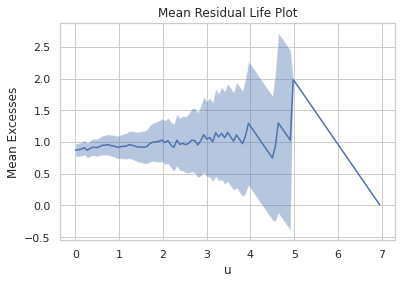

/usr/local/lib/python3.7/dist-packages/thresholdmodeling/thresh_modeling.py:111: RuntimeWarning: invalid value encountered in double_scalars
  CI_mod_scale.append((Var_mod_scale**0.5)*z) #getting the confidence interval for the


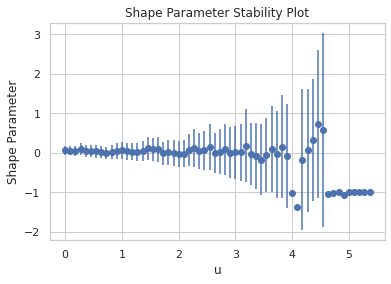

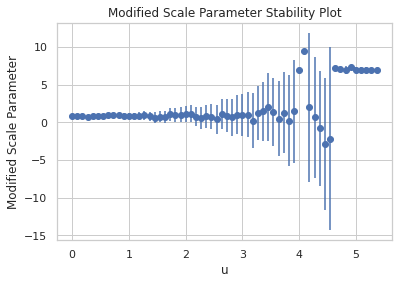

1.296271800504801


In [23]:
percentile_threshold = get_thresholds(hist_daily["Close_Returns"], 25, 90)
print(percentile_threshold)

Estimator: MLE 
 Deviance: 142.3731 
      AIC: 146.3731 

Varying Threshold: FALSE 

  Threshold Call: 1.296 
    Number Above: 75 
Proportion Above: 0.1009 

Estimates
  scale    shape  
0.91877  0.03387  

Standard Error Type: observed 

Standard Errors
 scale   shape  
0.1525  0.1192  

Asymptotic Variance Covariance
       scale     shape   
scale   0.02324  -0.01263
shape  -0.01263   0.01422

Optimization Information
  Convergence: successful 
  Function Evaluations: 18 
  Gradient Evaluations: 5 


Estimator: MLE 
 Deviance: 142.3731 
      AIC: 146.3731 

Varying Threshold: FALSE 

  Threshold Call: 1.296 
    Number Above: 75 
Proportion Above: 0.1009 

Estimates
  scale    shape  
0.91877  0.03387  

Standard Error Type: observed 

Standard Errors
 scale   shape  
0.1525  0.1192  

Asymptotic Variance Covariance
       scale     shape   
scale   0.02324  -0.01263
shape  -0.01263   0.01422

Optimization Information
  Convergence: successful 
  Function Evaluations: 18 
  Gradi

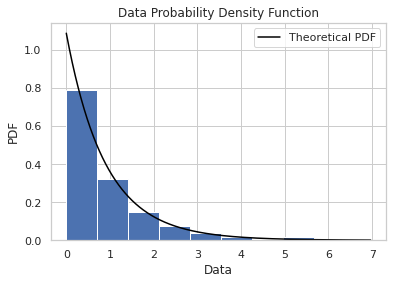

Estimator: MLE 
 Deviance: 142.3731 
      AIC: 146.3731 

Varying Threshold: FALSE 

  Threshold Call: 1.296 
    Number Above: 75 
Proportion Above: 0.1009 

Estimates
  scale    shape  
0.91877  0.03387  

Standard Error Type: observed 

Standard Errors
 scale   shape  
0.1525  0.1192  

Asymptotic Variance Covariance
       scale     shape   
scale   0.02324  -0.01263
shape  -0.01263   0.01422

Optimization Information
  Convergence: successful 
  Function Evaluations: 18 
  Gradient Evaluations: 5 




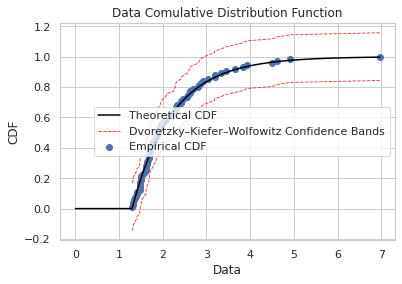

In [24]:
estimate_parameters(hist_daily['Close_Returns'], 25, 1.296)

In [25]:
find_percentage_of_remaining_in_99(hist_daily["Close_Returns"][1:], 25, 1.296, 0.919, 0.0339)

8.470984041899099
0.9990186588796588
10.579978508176161
0.9998313310955781
12.28684614166085
0.9999563634058494
6.11756613038999
0.992004086280921
4.0
151
percentage: 2.6490066225165565


2.6490066225165565

In [29]:
pdf = find_pdf_of_max_value(hist_daily["Close_Returns"][1:], 25, 1.296, 0.919, 0.0339)
print("pdf: " + str(pdf))

pdf: 3.378518323918541e-05


In [30]:
plot_returns_and_above_threshold_returns(hist_daily["Close_Returns"], 25, 1.296)